___
# Ciência dos Dados - PROJETO 2

___
## Beni Stern

## Leonardo Costa

## Gabriel Duarte

___

___

## 1. Problema

O Classificador Naive-Bayes, o qual se baseia no uso do teorema de Bayes, é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser SPAM considerando as palavras em seu conteúdo e, de forma complementar, permite calcular a probabilidade de uma mensagem ser HAM dada as palavras descritas na mensagem.

Para realizar o MVP (minimum viable product) do projeto, você precisa programar uma versão do classificador que "aprende" o que é uma mensagem SPAM considerando uma base de treinamento e comparar o desempenho dos resultados com uma base de testes. 


___
## 2. Separação da base de dados em Treinamento e Teste

A base de dados deve ser separada em duas partes, aleatoriamente, considerando: 
    
    75% dos dados para a parte Treinamento; e
    25% dos dados para a parte Teste.

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [241]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Duarte\Downloads\INSPER aqui tbm\DADOS DP\Projeto2\Projeto-2-Filtro-Spam


In [242]:
dados = pd.read_excel("spamham2019.xlsx")

In [243]:
def Embaralhar(dados):  
    dados_aleatorio = dados.sample(frac=1)
    dados_aleatorio = dados.sample(frac=1).reset_index(drop=True)
    dados_treinamento_suju = dados_aleatorio.loc[:4180:,:]
    dados_teste_suju = dados_aleatorio.loc[4180:,:]
    return dados_treinamento_suju,dados_teste_suju
dados_treinamento_suju,dados_teste_suju = Embaralhar(dados)

In [244]:
dados_treinamento_suju.head()

,Email,Class
0,Are you this much buzy,ham
1,"Aight, let me know when you're gonna be around...",ham
2,Hello. They are going to the village pub at 8 ...,ham
3,I love you. You set my soul on fire. It is not...,ham
4,I don't want you to leave. But i'm barely doin...,ham


In [245]:
dados_teste_suju.head()

,Email,Class
4180,Ok no prob...,ham
4181,Send this to ur friends and receive something ...,ham
4182,Sounds great! Im going to sleep now. Have a go...,ham
4183,Wot about on wed nite I am 3 then but only til 9!,ham
4184,Just finished. Missing you plenty,ham


___
## 3. Classificador Naive-Bayes

In [246]:
def Filtro(base):
    lista = []
    for e in base["Email"]:
        e = e.replace(",","").replace("/n", "").replace('""', "").replace("'", "").replace(":", "").replace(".", "").replace("...", "").replace(")", "").replace("(", "").replace("", "").replace("*", "").replace("#", "").replace(";", "").replace("&", "").replace("?", "")
        lista.append(e)
    base2 = pd.DataFrame({"Email":lista,"Class":base["Class"]})  
    return base2

dados_treinamento = Filtro(dados_treinamento_suju)
dados_teste = Filtro(dados_teste_suju)
dados_teste.head()

,Class,Email
4180,ham,Ok no prob
4181,ham,Send this to ur friends and receive something ...
4182,ham,Sounds great! Im going to sleep now Have a goo...
4183,ham,Wot about on wed nite I am 3 then but only til 9!
4184,ham,Just finished Missing you plenty


In [247]:
def PSH(dados):
    n_ham = dados["Class"].value_counts()[0]
    n_spam = dados["Class"].value_counts()[1]
    total = n_spam + n_ham

    P_ham = n_ham/total
    P_spam = n_spam/total
    return P_spam,P_ham
P_spam,P_ham=PSH(dados_treinamento)
print("P(SPAM) = ", P_spam)
print("P(HAM)  = ", P_ham)

P(SPAM) =  0.13322171729251375
P(HAM)  =  0.8667782827074862


In [248]:
def p_word(date,nome):
    frase = date["Email"]
    palavras_em_lista = []
    
    for linha in frase:
        lista_palavras = linha.split(" ")
        
        for p in lista_palavras:
            palavras_em_lista.append(p)        
    
    total_palavras = len(palavras_em_lista)
    
    palavras = pd.DataFrame(palavras_em_lista)
    contagem = palavras[0].value_counts()
    tabela_contagem = pd.DataFrame(contagem)
    nome_tabela = 'P(word|{})'.format(nome)
    final = tabela_contagem.rename(index=str,columns={0: "Quantidade"})
    
    final[nome_tabela] = final["Quantidade"]/total_palavras
    
    return final

P_wordSpam = p_word(dados_treinamento[dados_treinamento.Class == "spam"],"Spam")
P_wordHam = p_word(dados_treinamento[dados_treinamento.Class == "ham"],"Ham")
P_word = p_word(dados_treinamento," ")

P_wordSpam.head()

,Quantidade,P(word|Spam)
to,457,0.034143
a,270,0.020172
you,140,0.010459
call,139,0.010385
the,135,0.010086


In [249]:
def Classificador(Dados,data_ham,data_spam,data_word,p_ham,p_spam): 
    for mensagem in Dados['Email']:
        lista_palavras = mensagem.split(" ")
        p_data_ham=[]
        resu_ham=1

        p_data_spam=[]
        resu_spam=1

        p_word_total=[]
        resu_word=1
        
        # Juntando Lista de P(word|Ham) & P(Word|Spam) & P(word)
        for pa in lista_palavras:
            try:    
                p_msg_ham = data_ham.loc[pa][1]
                p_data_ham.append(p_msg_ham)
            except:
                p_data_ham.append(0.000015)

            try:    
                p_msg_spam = data_spam.loc[pa][1]
                p_data_spam.append(p_msg_spam)
            except:
                p_data_spam.append(0.000015)

            try:
                p_msg_word = data_word.loc[pa][0]
                p_word_total.append(p_msg_word)
            except:
                p_word_total.append(0.000015)
        
        # Calculando probrabilidade das frases P(mensagem|Ham) & P(mensagem|Spam) & P(mensagem)
        for p1 in p_data_spam:
            resu_ham *= p1
        for p2 in p_data_spam:
            resu_spam *= p2
        for p3 in p_word_total:
            resu_word *= p3
        
        # Calculando as probrabilidades P(Ham|mensagem) & P(Spam|mensagem)
        resu_ham2 = (resu_ham*p_ham)/resu_word
        resu_spam2 = (resu_spam*p_spam)/resu_word
        
        #Verificando qual é maior
        if resu_ham2 >= resu_spam2:
            resultado = "ham"
        else:
            resultado = "spam"
            
        Dados['Classificador'] = resultado
    return Dados

Teste = Classificador(dados_teste,P_wordHam,P_wordSpam,P_word,P_ham,P_spam)

In [250]:
Teste.head()

,Class,Email,Classificador
4180,ham,Ok no prob,ham
4181,ham,Send this to ur friends and receive something ...,ham
4182,ham,Sounds great! Im going to sleep now Have a goo...,ham
4183,ham,Wot about on wed nite I am 3 then but only til 9!,ham
4184,ham,Just finished Missing you plenty,ham


In [251]:
def Resultados(baze0):
    baze = baze0.reset_index(drop=True)
    Falso_positivo = 0
    Positivo_Verdadeiro = 0
    Falso_negativo = 0
    Negativos_verdadeiros = 0
    n = len(baze)
    for i in range(n):
        resultado = [baze['Class'][i],baze['Classificador'][i]]
        if resultado  == ['ham','ham']:
            Negativos_verdadeiros +=1
        if resultado  == ['spam','ham']:
            Falso_negativo +=1  
        if resultado  == ['spam','spam']:
            Positivo_Verdadeiro +=1
        if resultado  == ['ham','spam']:
            Falso_positivo +=1
    FP = Falso_positivo/n
    PV = Positivo_Verdadeiro/n
    FN = Falso_negativo/n
    NV = Negativos_verdadeiros/n
    
    return [FP,PV,FN,NV]

In [252]:
print('Falso positivo',Resultados(Teste)[0])
print('Positivo Verdadeiro ',Resultados(Teste)[1])
print('Falso negativo',Resultados(Teste)[2])
print('Negativos verdadeiro',Resultados(Teste)[3])

Falso positivo 0.0
Positivo Verdadeiro  0.0
Falso negativo 0.13649425287356323
Negativos verdadeiro 0.8635057471264368


Observando o resultado do classificador podemos observar que ele não classifica nenhuma mensagem como Spam, esse erro pode ser causado por existirem muito menos mensagens de Spam do que Ham, então o algoritmo aprende melhor o que é mensagens do tipo Ham.

___
## 4. Qualidade do Classificador alterando a base de treinamento

In [256]:
Salvos = []
for i in range(10000):
    treino_suju,teste_suju = Embaralhar(dados)
    treino = Filtro(treino_suju)
    teste = Filtro(teste_suju)
    P6,P5 = PSH(treino)
    
    P3 = p_word(treino[treino.Class == "spam"],"Spam")
    P2 = p_word(treino[treino.Class == "ham"],"Ham")
    P4 = p_word(treino," ")
    
    final = Classificador(teste,P2,P3,P4,P5,P6)
    Res = Resultados(final)
    R = Res[3]+Res[1]
    Salvos.append(R)

,0
count,100.000000
mean,0.865984
std,0.007862
min,0.845546
25%,0.862069
50%,0.865661
75%,0.871408
max,0.890086


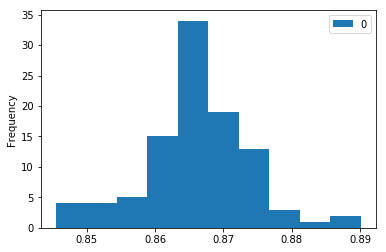

In [261]:
salvos = pd.DataFrame(Salvos)
salvos.plot.hist()
salvos.describe()

Podemos ver que o gráfico forma uma curva normal com média igual a 0.86, com ela podemos ter muito mais certeza sobre a qualidadade do nosso classificador .